<a href="https://colab.research.google.com/github/Valasik0/HU-final-project/blob/main/HU_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [52]:
import kagglehub
import zipfile
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential

# Description and Exploratory data analysis

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"vclavvyrobk","key":"b22968f879ef4b522594bb7537095efd"}'}

In [4]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d amananandrai/ag-news-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset
License(s): unknown
  0% 0.00/11.4M [00:00<?, ?B/s]
100% 11.4M/11.4M [00:00<00:00, 622MB/s]


In [6]:
with zipfile.ZipFile("ag-news-classification-dataset.zip", 'r') as zip_ref:
    zip_ref.extractall("ag_news")

In [24]:
train_df = pd.read_csv("ag_news/train.csv")
test_df = pd.read_csv("ag_news/test.csv")

In [ ]:
train_df.head()

,Class Index,Title,Description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
len(train_df)

120000

In [ ]:
test_df.head()

,Class Index,Title,Description
0,3,Fears for T N pension after talks,Unions representing workers at Turner Newall...
1,4,The Race is On: Second Private Team Sets Launc...,"SPACE.com - TORONTO, Canada -- A second\team o..."
2,4,Ky. Company Wins Grant to Study Peptides (AP),AP - A company founded by a chemistry research...
3,4,Prediction Unit Helps Forecast Wildfires (AP),AP - It's barely dawn when Mike Fitzpatrick st...
4,4,Calif. Aims to Limit Farm-Related Smog (AP),AP - Southern California's smog-fighting agenc...


In [ ]:
len(test_df)

7600

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Class Index  120000 non-null  int64 
 1   Title        120000 non-null  object
 2   Description  120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [25]:
train_df.columns = ['class_index', 'title', 'description']
test_df.columns = ['class_index', 'title', 'description']

In [ ]:
train_df.head()

,class_index,title,description
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


In [ ]:
categories = train_df['class_index'].unique()
categories

array([3, 4, 2, 1])

From kaggle dataset informations the classes are World, Sports, Business, Sci/Tech.

In [ ]:
train_df['title'][0]

'Wall St. Bears Claw Back Into the Black (Reuters)'

In [ ]:
categories_distribution = train_df['class_index'].value_counts()
categories_distribution

,count
class_index,
3,30000
4,30000
2,30000
1,30000


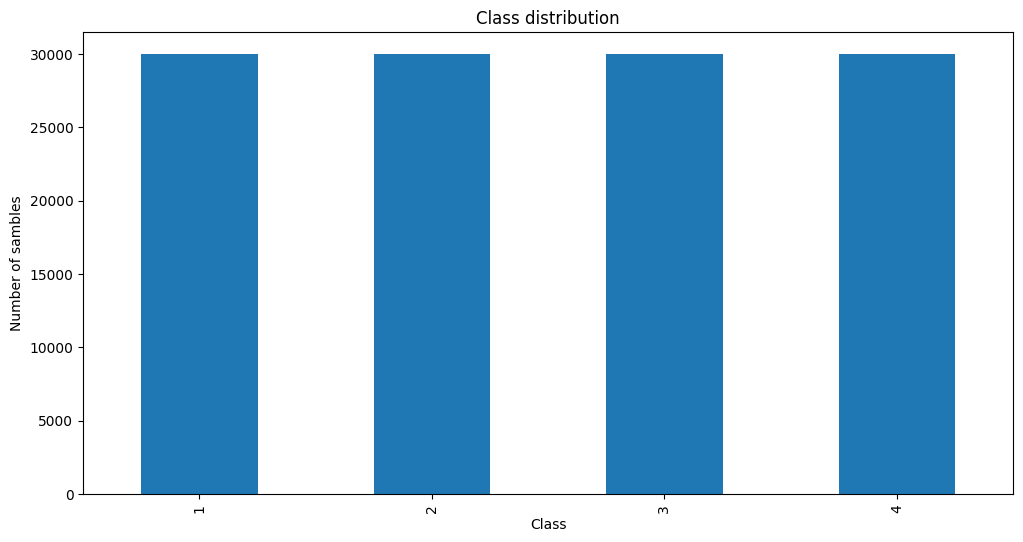

In [ ]:
plt.figure(figsize=(12, 6))
train_df['class_index'].value_counts().sort_index().plot(kind='bar')
plt.title('Class distribution')
plt.xlabel('Class')
plt.ylabel('Number of sambles')
plt.show()

As we can see in the picture, the classes are equally distributed so I don't have to handle uneven classes. So for the metric I will use accuracy.

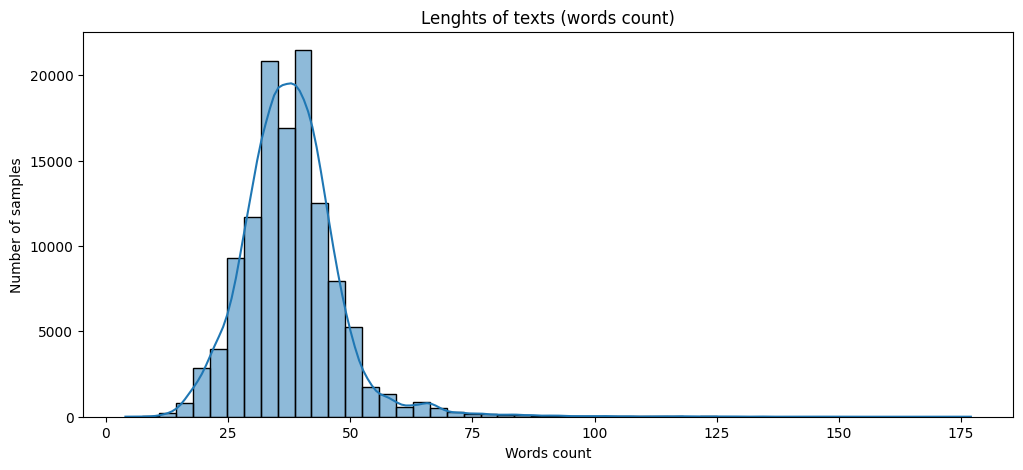

In [26]:
train_df['text_len'] = train_df['title'].apply(lambda x: len(x.split())) + train_df['description'].apply(lambda x: len(x.split()))

plt.figure(figsize=(12,5))
sns.histplot(train_df['text_len'], bins=50, kde=True)
plt.title("Lenghts of texts (words count)")
plt.xlabel("Words count")
plt.ylabel("Number of samples")
plt.show()

In [ ]:
max(train_df['text_len'])

177

In [ ]:
min(train_df['text_len'])

4

In [ ]:
avg = sum(train_df['text_len'])/len(train_df['text_len'])
avg

37.84461666666667

Lenghts of texts (features for mofel) are mostly between 25 to 50 words. There are also some long text up to 177 words.

### Data preparation

In [27]:
train_df['text'] = train_df['title'] + ' ' + train_df['description']
test_df['text'] = test_df['title'] + ' ' + test_df['description']

In [28]:
train_df = train_df.drop(columns=['title', 'description', 'text_len'])
test_df = test_df.drop(columns=['title', 'description'])

In [ ]:
train_df.head()

,class_index,text
0,3,Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new..."


In [29]:
test_df.head()

,class_index,text
0,3,Fears for T N pension after talks Unions repre...
1,4,The Race is On: Second Private Team Sets Launc...
2,4,Ky. Company Wins Grant to Study Peptides (AP) ...
3,4,Prediction Unit Helps Forecast Wildfires (AP) ...
4,4,Calif. Aims to Limit Farm-Related Smog (AP) AP...


I merged columns title and description to be one column (feature for model) - text.

In [ ]:
train_df['text'][0]

"Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again."

In [ ]:
train_df['text'][10]

"Oil and Economy Cloud Stocks' Outlook  NEW YORK (Reuters) - Soaring crude prices plus worries  about the economy and the outlook for earnings are expected to  hang over the stock market next week during the depth of the  summer doldrums."

### Cleaning data

In [13]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [15]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = text.split()
    cleaned_words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(cleaned_words)

In [30]:
train_df['clean_text'] = train_df['text'].apply(preprocess_text)
test_df['clean_text'] = test_df['text'].apply(preprocess_text)

In [17]:
train_df['clean_text'][10]

'oil economy cloud stock outlook new york reuters soaring crude price plus worry economy outlook earnings expected hang stock market next week depth summer doldrums'

In [18]:
train_df['text'][10]

"Oil and Economy Cloud Stocks' Outlook  NEW YORK (Reuters) - Soaring crude prices plus worries  about the economy and the outlook for earnings are expected to  hang over the stock market next week during the depth of the  summer doldrums."

In [31]:
test_df['clean_text'][10]

'group propose new highspeed wireless format los angeles reuters group technology company including texas instrument inc lttxnngt stmicroelectronics ltstmpagt broadcom corp ltbrcmogt thursday said propose new wireless networking standard time speed current generation'

In [32]:
test_df['text'][10]

'Group to Propose New High-Speed Wireless Format  LOS ANGELES (Reuters) - A group of technology companies  including Texas Instruments Inc. &lt;TXN.N&gt;, STMicroelectronics  &lt;STM.PA&gt; and Broadcom Corp. &lt;BRCM.O&gt;, on Thursday said they  will propose a new wireless networking standard up to 10 times  the speed of the current generation.'

### Tokenization

In [33]:
X_train = train_df['clean_text']
y_train = train_df['class_index']

In [34]:
X_test = test_df['clean_text']
y_test = test_df['class_index']

In [35]:
unique_words = set()
for text in X_train:
    for word in text.split():
        unique_words.add(word)
num_unique_words = len(unique_words)
num_unique_words

84023

In [37]:
num_words = 30000
tokenizer = Tokenizer(num_words=num_words, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [38]:
X_train_seq[0]

[346, 294, 1124, 10830, 58, 695, 5, 5, 1, 346, 236, 1, 1, 3477, 658]

In [39]:
X_test_seq[0]

[508,
 2021,
 975,
 97,
 164,
 3531,
 268,
 5649,
 1,
 12,
 4060,
 97,
 9532,
 1247,
 156,
 138,
 7192]

Number of unique words in my train set is 84023, so I set number of words to be tokenized to 30000 (most frequent words). Other words I think are not so important so they will be 'UNK>'.

In [40]:
lengths = [len(seq) for seq in X_train_seq]

In [41]:
max(lengths)

100

In [44]:
np.mean(lengths)

np.float64(24.759016666666668)

In [45]:
np.percentile(lengths, 95)

np.float64(34.0)

In [47]:
maxlen = 34

In [49]:
X_train_pad = pad_sequences(X_train_seq, maxlen=maxlen, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=maxlen, padding='post', truncating='post')

In [50]:
X_train_pad[0]

array([  346,   294,  1124, 10830,    58,   695,     5,     5,     1,
         346,   236,     1,     1,  3477,   658,     0,     0,     0,
           0,     0,     0,     0,     0,     0], dtype=int32)

In [51]:
X_test_pad[0]

array([ 508, 2021,  975,   97,  164, 3531,  268, 5649,    1,   12, 4060,
         97, 9532, 1247,  156,  138, 7192,    0,    0,    0,    0,    0,
          0,    0], dtype=int32)

I calculated mean (24), max (100) 95 percentile (34) of text lengths so I can choose max length (34) for paddings. Now all the sequences will be the same length (long sequences greater then 34 will bu truncated, but its negligible when 95% of sequences are <= 34).

### One-hot encoding

In [53]:
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc = le.transform(y_test)
y_train_oh = to_categorical(y_train_enc)
y_test_oh = to_categorical(y_test_enc)

In [54]:
y_train_oh[0]

array([0., 0., 1., 0.])

In [55]:
y_test_oh[0]

array([0., 0., 1., 0.])

# Custom models